In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

In [44]:
data = pd.read_excel('tim_data/tim_all_cofactors.xlsx')
data = data.assign(Done=[False for i in range(len(data))])
data.head()

,Name,Layer,Count,Parent,Done
0,Iron,1,200000,Root,False
1,Zinc,1,150000,Root,False
2,Copper,1,75000,Root,False
3,ETC,2,75000,Iron,False
4,Sox,2,50000,Iron,False


In [45]:
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels, widths, colors = [], [], []
        random_color = list(mcolors.TABLEAU_COLORS)[np.random.randint(0, len(mcolors.TABLEAU_COLORS))]
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            colors.append(random_color) if label != '' else colors.append('black')
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge', color=colors)
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        
        plt.savefig('tim_data/all_sunburst.png', bbox_inches='tight')

In [46]:
parent_layer_sums = {}
parent_list = data['parent'].unique().tolist()
# layer_list = data['Layer'].unique().tolist()
# max_layer = max(layer_list)

for parent in parent_list:
#    for layer in layer_list:
    cur_sum = 0
    for index, row in data.iterrows():
        if row['parent'] == parent: #and index != len(data) - 1:
            cur_sum += row['count']
    parent_layer_sums[parent] = cur_sum
        
print(parent_layer_sums)

{('Root', 1): 425000, ('Root', 2): 0, ('Root', 3): 0, ('Iron', 1): 0, ('Iron', 2): 125000, ('Iron', 3): 0, ('Zinc', 1): 0, ('Zinc', 2): 90000, ('Zinc', 3): 0, ('Copper', 1): 0, ('Copper', 2): 40000, ('Copper', 3): 0, ('ETC', 1): 0, ('ETC', 2): 0, ('ETC', 3): 65000, ('Sox', 1): 0, ('Sox', 2): 0, ('Sox', 3): 40000, ('Tx', 1): 0, ('Tx', 2): 0, ('Tx', 3): 40000, ('Tl', 1): 0, ('Tl', 2): 0, ('Tl', 3): 25000, ('Glycol', 1): 0, ('Glycol', 2): 0, ('Glycol', 3): 0}


### Version that uses percentages (deprecated)

In [47]:
def transform_data_percent(df, data_tuple, parent_name, parent_value, cur_layer):
    df['Done'] = df['Done'].astype(bool)
    children = df[(df['Layer'] == cur_layer) & (df['Parent'] == parent_name) & (df['Done'] == False)]
    print(children)
    for _, child in children.iterrows():
        child_value = 0
        if parent_layer_sums[(parent_name, cur_layer)] != 0:
            child_value = child['Count'] / parent_layer_sums[(parent_name, cur_layer)] * parent_value
        child_tuple = (child['Name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_percent(df, child_tuple, child['Name'], child_value, cur_layer + 1)

## Version that uses actual count values


In [48]:
def layer_fill(df, data_tuple, cur_layer, parent_value):
    child_tuple = ('', parent_value, [])
    data_tuple[2].append(child_tuple)  
    if cur_layer != max_layer:
        layer_fill(df, child_tuple, cur_layer + 1, parent_value)

def transform_data_count(df, data_tuple, parent_id, parent_value, cur_layer):
    df['done'] = df['done'].astype(bool)
    children = df[(df['parent'] == parent_id) & (df['done'] == False)]
    layer_sum = 0
    for _, child in children.iterrows():
        child_value = child['count']
        layer_sum += child_value
        child_tuple = (child['name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_count(df, child_tuple, child['plot_id'], child_value, cur_layer + 1)

    if layer_sum != parent_value and len(data_tuple[2]) != 0:
        child_tuple = ('', parent_value - layer_sum, [])
        data_tuple[2].append(child_tuple)
        
        # if cur_layer != max_layer:
            # layer_fill(df, child_tuple, cur_layer + 1, parent_value - layer_sum)

root_value = parent_layer_sums[('Root', 1)]
data_transformed = [('Root', root_value, [])]
transform_data_count(data, data_transformed[0], -1, root_value, 1)
print(data_transformed)


[('Root', 425000, [('Iron', 200000, [('ETC', 75000, [('NDH-1', 40000, []), ('SDH', 25000, []), ('', 10000, [])]), ('Sox', 50000, [('SodA', 40000, []), ('', 10000, [])]), ('', 75000, [('', 75000, [])])]), ('Zinc', 150000, [('Tx', 40000, [('RpoC', 40000, [])]), ('Tl', 30000, [('RpmM', 25000, []), ('', 5000, [])]), ('Glycol', 20000, [('PfkA', 15000, []), ('', 5000, [])]), ('', 60000, [('', 60000, [])])]), ('Copper', 75000, [('ETC', 40000, []), ('', 35000, [('', 35000, [])])])])]


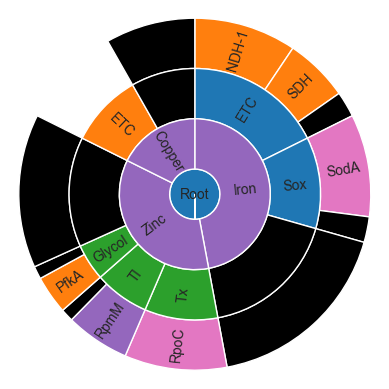

In [49]:
sunburst(data_transformed)